# Projeto Recuperação da Informação - Kmeans

In [83]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as p
import random
import nltk as n
import matplotlib.pyplot as plt
import re
import seaborn as sb
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from scipy.spatial.distance import cdist
from collections import Counter
from sklearn.cluster import KMeans
from wordcloud import WordCloud
from sklearn.manifold import TSNE
from unicodedata import normalize

Texto

In [70]:
def build(data):
    data["noticia"] = data.titulo + " " + data.subTitulo + " " + data.conteudo
    docs = []
    stop_words = set(stopwords.words('portuguese'))
    
    for index, doc in data.iterrows():
        doc.noticia = doc.noticia.lower()
        word_tokens = word_tokenize(doc.noticia)
        filtered_sentence = [w for w in word_tokens if not w in stop_words]
        news = ' '.join(filtered_sentence)
        docs.append(clear_text(news))

    return docs

In [71]:
def clear_text(text):
    pattern = re.compile('[^a-zA-Z0-9 ]')
    text = normalize('NFKD', text).encode('ASCII', 'ignore').decode('ASCII')
    return pattern.sub(' ', text)

Texto

In [81]:
file_csv = "data-set/estadao_noticias_eleicao.csv"
num_lines = sum(1 for l in open(file_csv))

# ~10%
size = int(num_lines / 10)
skip_idx = random.sample(range(1, num_lines), num_lines - size)
data = p.read_csv(file_csv, skiprows=skip_idx, encoding = "utf-8")
data = data.replace(np.NAN, "")
documents = build(data)

Texto

In [73]:
vectorizer = TfidfVectorizer()
vector = vectorizer.fit_transform(documents)

Texto

In [93]:
## O NÚMERO MÁXIMO DE POSSÍVEIS CLUSTERS É N. A QUANTIDADE DE EXPERIÊNCIAS
K = range(1,10)
# k means determine k
distortions = []

for k in K:
    kmeanModel = KMeans(n_clusters=k, init='k-means++', max_iter=10000, n_init=100).fit(vector.toarray())
    kmeanModel.fit(vector.toarray())
    distortions.append(sum(np.min(cdist(vector.toarray(), kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / vector.toarray().shape[0])

KeyboardInterrupt: 

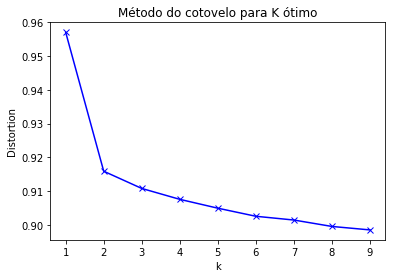

In [85]:
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Método do cotovelo para K ótimo')
plt.show()

Texto

In [92]:
km = KMeans(n_clusters= 4, init='k-means++', max_iter=10000, n_init=100)
km.fit(vector.toarray())

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=10000,
    n_clusters=4, n_init=100, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Texto

In [ ]:
labels = km.labels_
centroids = np.array(km.cluster_centers_)

Texto

In [ ]:
groups_dic = {}
groups_term_freq = {}

for i in range(len(documents)):
    groups_dic.setdefault(labels[i], []).append(documents[i])

for group in groups_dic.keys():
    groups_dic[group] = ' '.join(groups_dic[group])
    words = [word.lower() for word in n.word_tokenize(groups_dic[group])]
    freq_words = Counter(words)
    groups_term_freq[group] = freq_words.most_common()

    wordcloud = WordCloud(background_color='white', max_font_size=40).generate(groups_dic[group])
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title('Word Cloud do grupo ' + str(group))
    plt.axis("off")

Texto

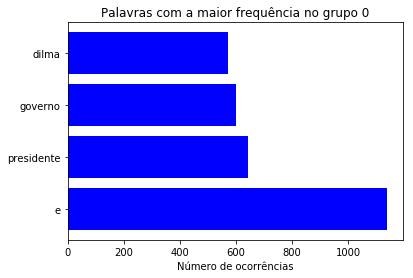

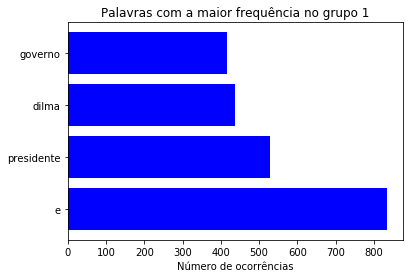

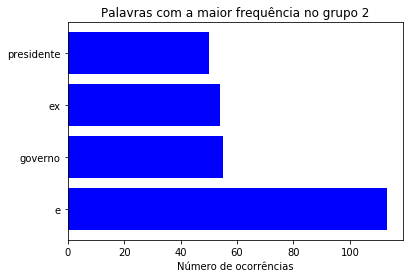

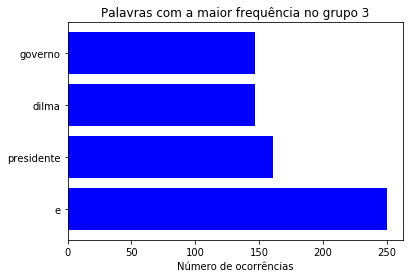

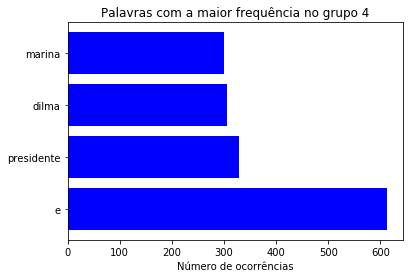

In [91]:
for group in groups_term_freq.keys():
    s = groups_term_freq[group][:4]
    y = []
    x = []
    for i in range(len(s)):
        x.append(s[i][0])
        y.append(s[i][1])

    plt.figure()
    plt.barh(x, y, color="blue")
    plt.xlabel("Número de ocorrências")
    plt.title("Palavras com a maior frequência no grupo " + str(group))

LinAlgError: singular matrix

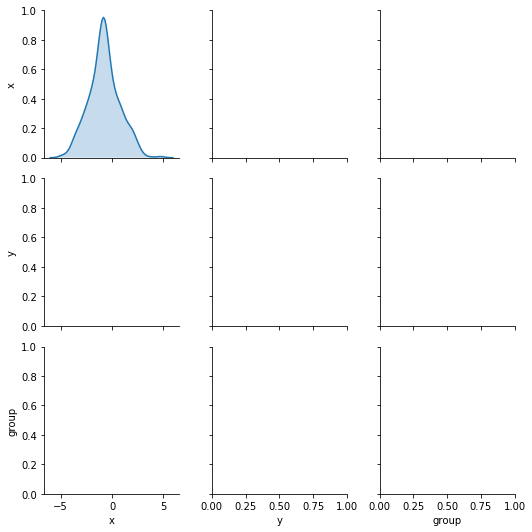

In [79]:
tsne_init = 'pca'  # could also be 'random'
tsne_perplexity = 20.0
tsne_early_exaggeration = 4.0
tsne_learning_rate = 1000
random_state = 1

model = TSNE(n_components=2, random_state=random_state, init=tsne_init, perplexity=tsne_perplexity,
         early_exaggeration=tsne_early_exaggeration, learning_rate=tsne_learning_rate)

model2 = TSNE(n_components=2, random_state=random_state, init=tsne_init, perplexity=tsne_perplexity,
         early_exaggeration=tsne_early_exaggeration, learning_rate=tsne_learning_rate)

transformed_centroids = model.fit_transform(centroids)
point = model2.fit_transform(vector.toarray())

df = p.DataFrame(point, index = [i for i in range(len(point))], columns = ['x','y'])
df['group'] = labels

sb.pairplot(df, 'group')
# colmap = {1: 'r', 2: 'g', 3: 'b'}
# plt.figure()
# plt.title("Grupos criados pelo algoritmo Kmeans")
# plt.scatter(df['x'], df['y'], color='black')
# plt.scatter(transformed_centroids[:, 0], transformed_centroids[:, 1], marker="x")


# plt.figure()
# plt.title("Grupos criados pelo algoritmo Kmeanssdfsdsdfsd")
# plt.scatter(df['x'], df['y'], color='black')
# plt.scatter(transformed_centroids[:, 0], transformed_centroids[:, 1], marker="x")


plt.show()